# Problem Instantiating using [deap](https://github.com/deap/deap)

## Prérequis

In [0]:
!pip install deap
# !pip show matplotlib
# !pip show IPython
# !python --version

In [0]:
from numpy.linalg import norm
import numpy

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation

from deap import creator, base, tools, algorithms
import math

## Génération des individus

In [0]:
def generate_random_lhd(nb_samples, nb_variables):
  return lhs(nb_variables, samples=nb_samples, criterion='center').flatten()

In [0]:
def generate_random_float_array(nb_samples, nb_variables):
  return numpy.random.rand(nb_samples, nb_variables).flatten()

In [0]:
def generate_random_int_array(nb_samples, nb_variables):
  return numpy.random.randint(low=0, high=nb_samples, size=(nb_samples, nb_variables)).flatten()

## Définition des critères

In [0]:
def criteria(func_list, sfd, nb_samples, nb_variables):
  return [f(sfd, nb_samples, nb_variables) for f in func_list]

### Critère AE

In [0]:
def ae_objective(lhd, nb_samples, nb_variables):
  lhd = lhd.reshape(nb_samples, nb_variables)
  res = 0
  for i in range(NB_SAMPLES-1):
    for j in range(i+1, NB_SAMPLES):
      dist = norm(lhd[i] - lhd[j])
      res += float("Inf") if dist == 0 else 1/dist
  return res

### Critère KL sur tout l'espace

In [0]:
def H(X, nb_samples, nb_variables):
  X = X.reshape(nb_samples, nb_variables)
  H = 0
  n = nb_samples

  for k in range(n):
    H += numpy.log(f(X, k, nb_samples, nb_variables))
  H = -(1/n) * H
  return H

def f(X, k, nb_samples, nb_variables):
  n = nb_samples
  d = nb_variables
  h = (1/math.sqrt(12)) * (1/n ** (1/(d+4)))
  f = 0 

  for i in range(n):
    f += K((X[k] - X[i]) / h, d)

  f = (1/(n * (h**d))) * f 
  return f

def K(z, nb_variables):
  d = nb_variables
  s = d/12
  C = ((2 * math.pi) ** (-d/2)) / (s**d) 
  K = C * numpy.exp(-(1/ (2*s ** 2)) * numpy.linalg.norm(z)**2)
  return K

### Critère KL par projection sur les axes

In [0]:
def H_projection(X, nb_samples, nb_variables):
  res = 0
  X = X.reshape(nb_samples, nb_variables)
  for axe in range(nb_variables):
    x = X[:, axe]
    res += H(x, nb_samples, 1)
  return res

## Préparation de l'algorithme

### Initialisation des hyperparamètres

In [0]:
NB_VARIABLES = 10
NB_SAMPLES = 10
NGEN = 30
MU = 20
LAMBDA = 20
CXPB = 0.7
MUTPB = 0.2

### Création des individus et du problème MO

In [0]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", numpy.ndarray, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

def initIntIndividual(icls): 
  return icls(generate_random_int_array(NB_SAMPLES, NB_VARIABLES))

def initFloatIndividual(icls):
  return icls(generate_random_float_array(NB_SAMPLES, NB_VARIABLES))

def initLHDIndividual(icls):
  return icls(generate_random_lhd(NB_SAMPLES, NB_VARIABLES))

toolbox.register("individual", initFloatIndividual, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [0]:
def evaluation(individual, criterion, nb_samples, nb_variables):
  return criteria(criterion, individual, nb_samples, nb_variables)

## Algorithme NSGA-II

In [0]:
toolbox.register("evaluate", evaluation, criterion=[H, H_projection], nb_samples=NB_SAMPLES, nb_variables=NB_VARIABLES)
toolbox.register("mate", tools.cxOnePoint)

# individual – Sequence individual to be mutated.
# eta – Crowding degree of the mutation. A high eta will produce a mutant resembling its parent, while a small eta will produce a solution much more different.
# low – A value or a sequence of values that is the lower bound of the search space.
# up – A value or a sequence of values that is the upper bound of the search space.

toolbox.register("mutate", tools.mutPolynomialBounded, eta=1, low=0, up=1, indpb=0.5)
toolbox.register("select", tools.selNSGA2)

In [0]:
def MOLHD(): 
    
    pop = toolbox.population(n=MU)
    hof = tools.ParetoFront(similar=numpy.array_equal)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    	
#     population – A list of individuals.
#     toolbox – A Toolbox that contains the evolution operators.
#     mu – The number of individuals to select for the next generation.
#     lambda_ – The number of children to produce at each generation.
#     cxpb – The probability that an offspring is produced by crossover.
#     mutpb – The probability that an offspring is produced by mutation.
#     ngen – The number of generation.
#     stats – A Statistics object that is updated inplace, optional.
#     halloffame – A HallOfFame object that will contain the best individuals, optional.
    
    pop, stats = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                              halloffame=hof)
    
    return pop, stats, hof

In [0]:
pop, stats, hof = MOLHD()

gen	nevals	avg                        	std                    	min                        	max                        
0  	20    	[ -4.40147862 -12.16722227]	[0.00265989 0.37747747]	[ -4.41279382 -12.98576263]	[ -4.40050029 -11.27842772]
1  	18    	[ -4.40065927 -12.01503142]	[2.74742271e-04 5.38453279e-01]	[ -4.40174422 -12.93762034]	[ -4.40050029 -11.18228667]
2  	15    	[ -4.40061256 -11.84426409]	[2.63360271e-04 5.30225829e-01]	[ -4.40174422 -12.85410589]	[ -4.40050029 -11.18228667]
3  	19    	[ -4.4006721  -11.81998518]	[4.05096590e-04 5.57453447e-01]	[ -4.40200312 -12.85410589]	[ -4.40049312 -11.18228667]
4  	19    	[ -4.40088654 -11.59343844]	[0.00100194 0.46086652]        	[ -4.40494744 -12.91651975]	[ -4.40048708 -11.09843066]
5  	18    	[ -4.40096206 -11.3057692 ]	[0.00101077 0.20289805]        	[ -4.40494744 -11.90690417]	[ -4.40048517 -10.84098245]
6  	20    	[ -4.40085075 -11.34122461]	[0.00104265 0.26918935]        	[ -4.40494744 -11.9560131 ]	[ -4.40048517 -10.84098245]


## Visualisation des individus retenus

In [0]:
import numpy as np

In [0]:
def normalize(x):
  return (x - x.min(0)) / x.ptp(0)

In [0]:
def generate_label(pareto):
  return ["Ind" + str(i) for i in range(len(pareto))]
        

In [0]:
def plot_at_y(arr, val):
    plt.plot(arr, np.zeros_like(arr) + val, 'x')
    plt.show()

In [0]:
def visualize_axes(ind):
  nb_samples, nb_dim = ind.shape
  for d in range(nb_dim):
    plot_at_y(ind[:, d],0)

In [0]:
def visualize(ind):
  ind = ind.transpose()
  for i in range(0, ind.shape[0]-1):
    plt.title("Dim " + str(i) + ":" + str(i+1))
    plt.xlabel("dimension " + str(i))
    plt.ylabel("dimension " + str(i+1))
    plt.scatter(ind[i], ind[i+1])
    plt.show()

In [0]:
def visualize_individuals(hof):
  for i in range(len(hof)):
    ind = hof[i].reshape(NB_SAMPLES, NB_VARIABLES)
    print("======================================================")
    print("Individual #" + str(i))
#     print(ind)
    visualize_axes(ind)
    visualize(ind)

In [0]:
def visualize_pareto(hof):
  hof_fitness = numpy.asarray([ind.fitness.values for ind in hof])
  norm_hof_fitness = normalize(hof_fitness)
  labels = generate_label(hof_fitness)
  print(norm_hof_fitness)
  plt.title("Pareto front ")
  plt.xlabel("KL all")
  plt.ylabel("KL projection")
  for label, x, y in zip(labels, norm_hof_fitness[:, 0], norm_hof_fitness[:, 1]):
    plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.scatter(x, y)
  plt.show()

### Visualisation du front de Pareto

[[1.         0.        ]
 [0.97697979 0.47656887]
 [0.88601867 0.57014997]
 [0.77192295 0.85450634]
 [0.77184738 0.90331564]
 [0.         1.        ]]


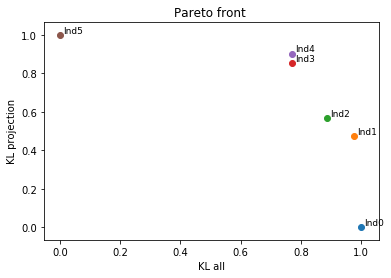

In [0]:
visualize_pareto(hof)
  

### Visualisation des individus 

Individual #0


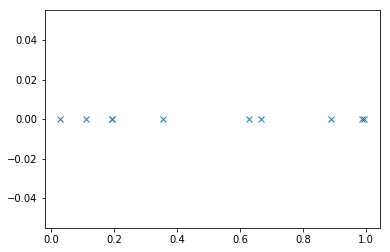

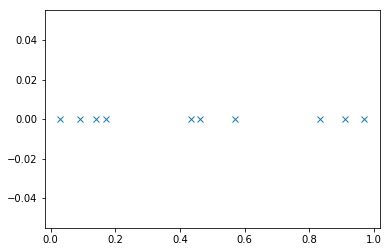

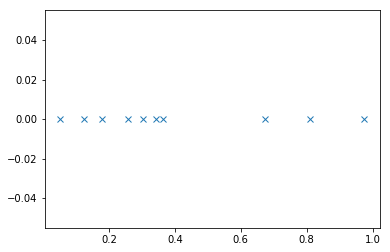

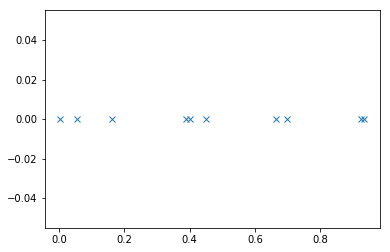

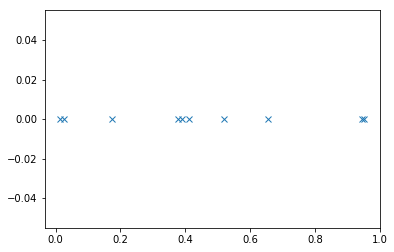

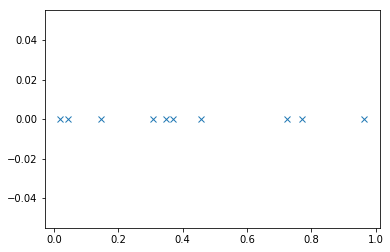

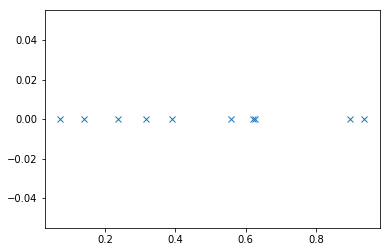

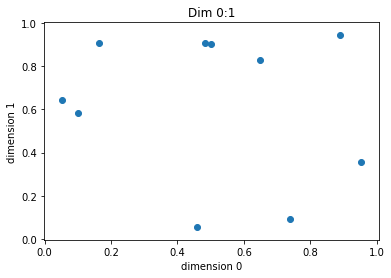

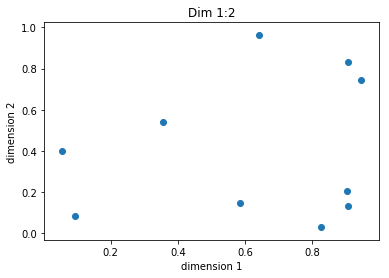

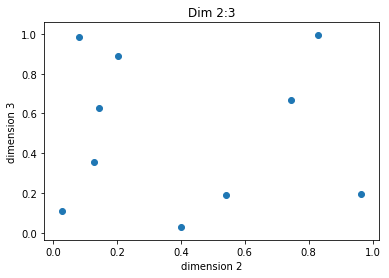

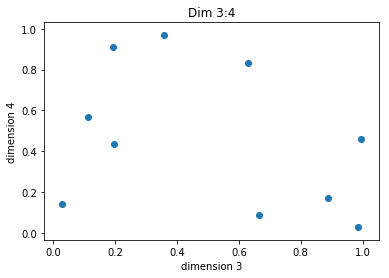

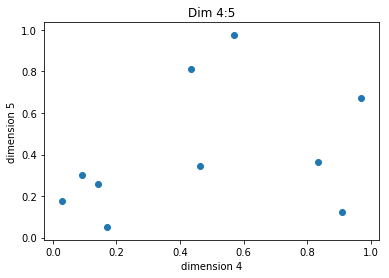

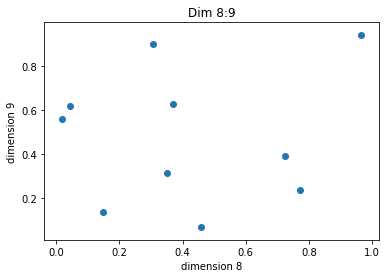

Individual #1


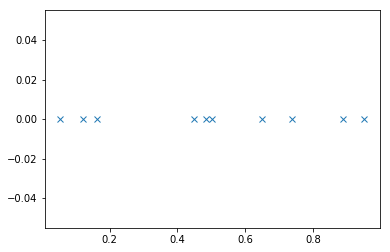

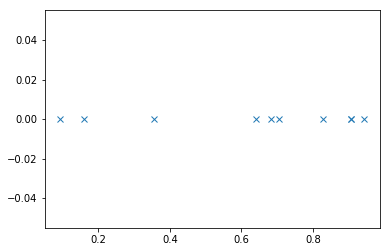

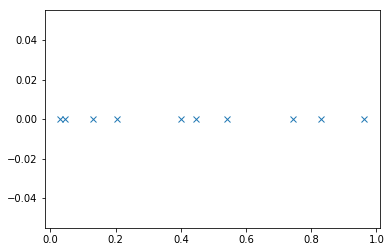

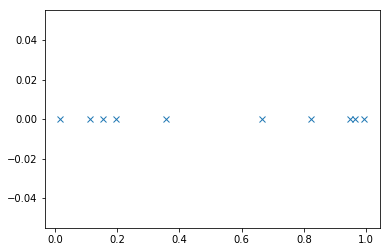

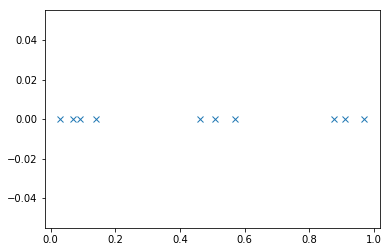

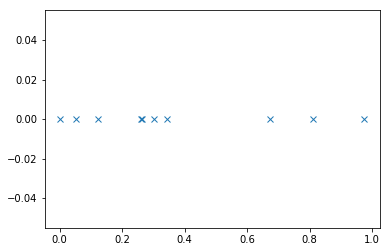

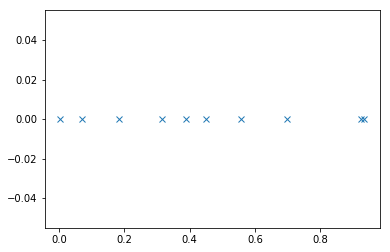

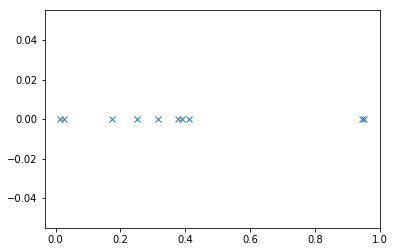

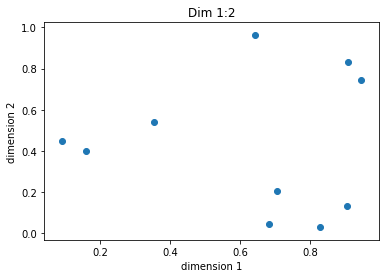

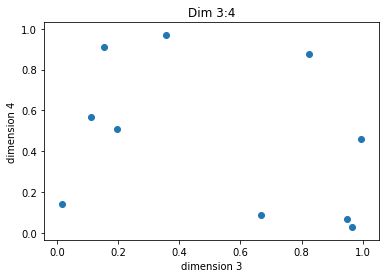

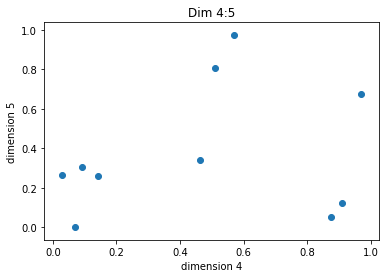

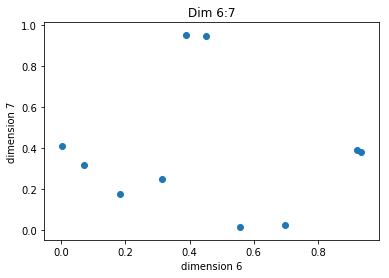

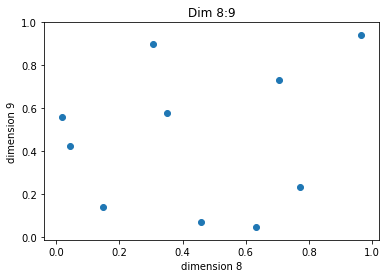

Individual #2


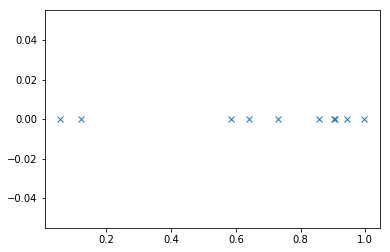

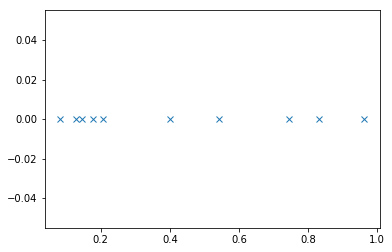

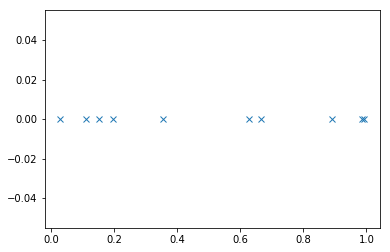

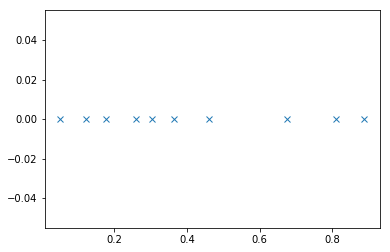

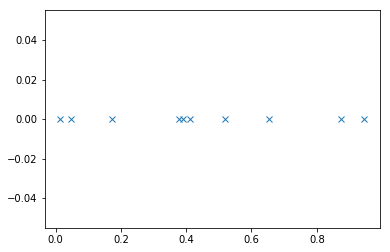

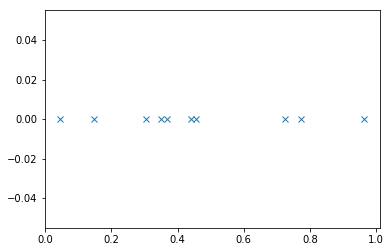

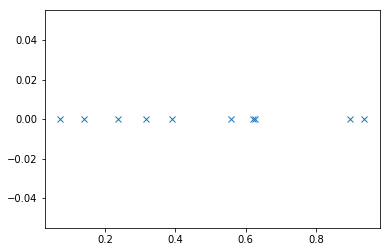

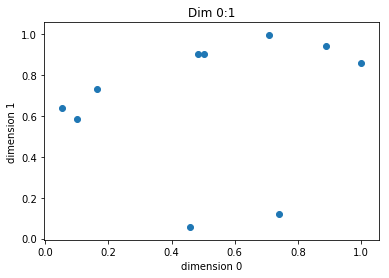

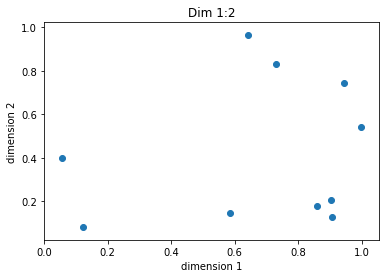

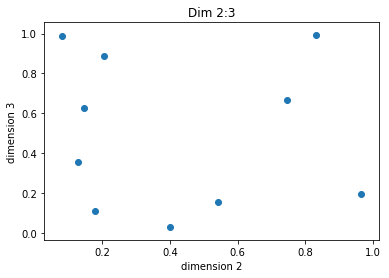

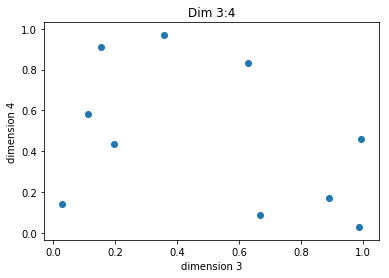

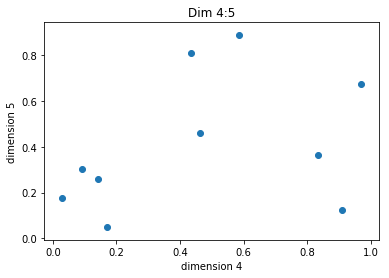

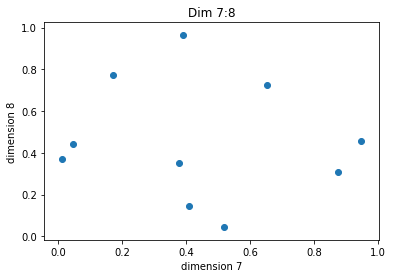

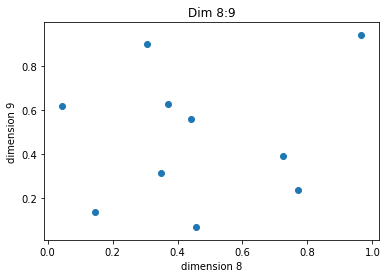

Individual #3


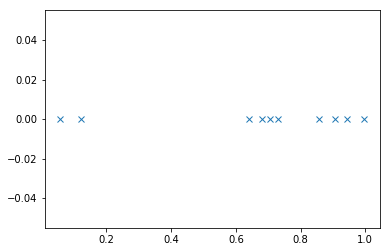

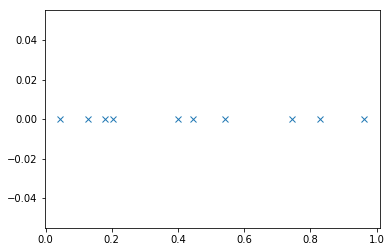

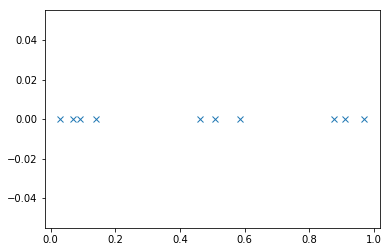

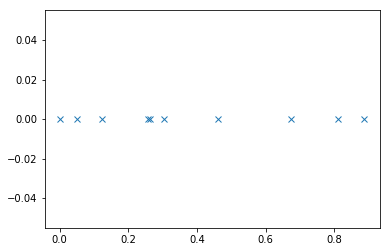

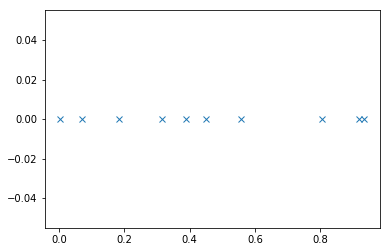

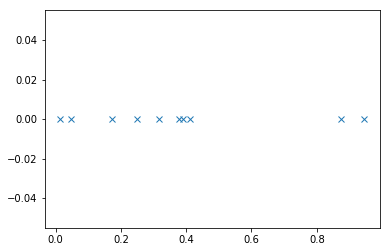

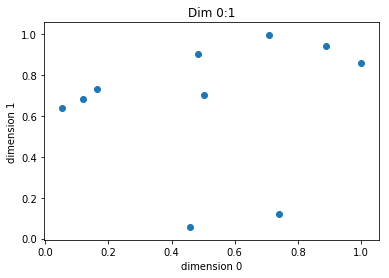

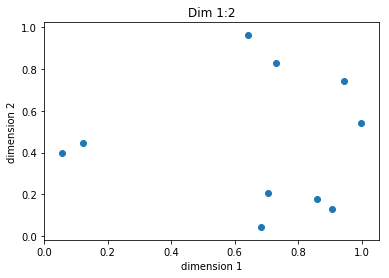

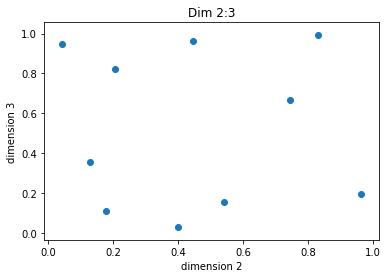

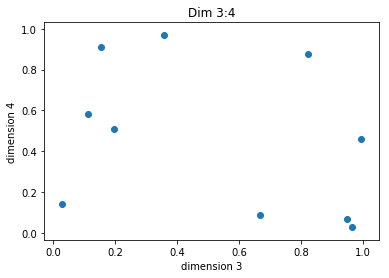

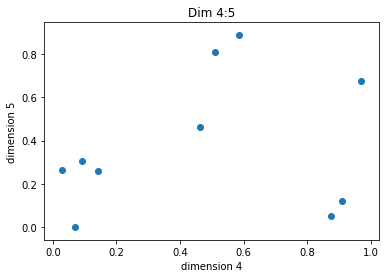

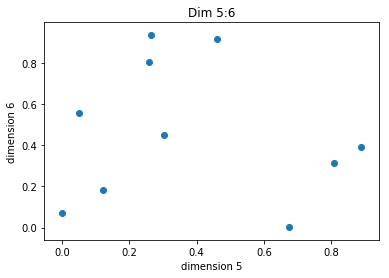

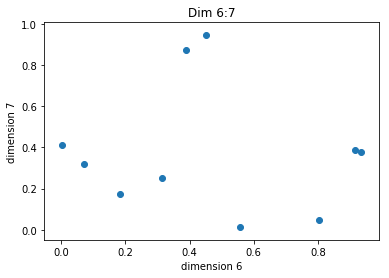

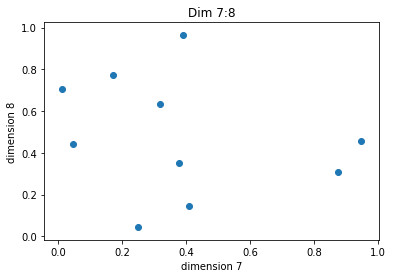

Individual #4


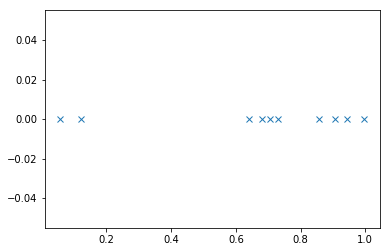

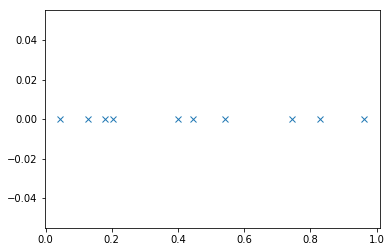

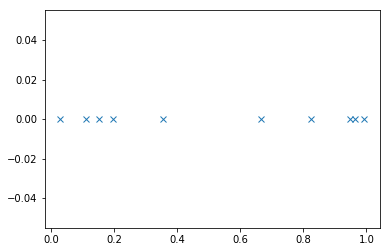

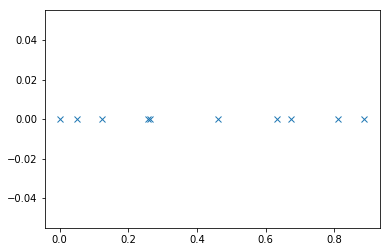

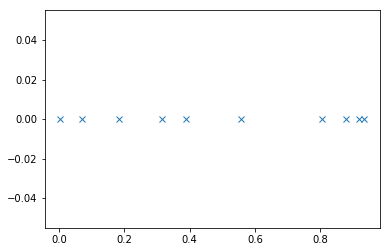

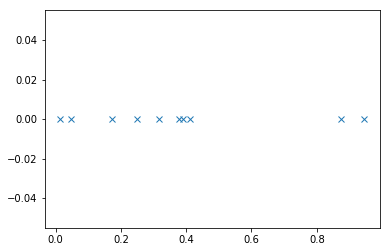

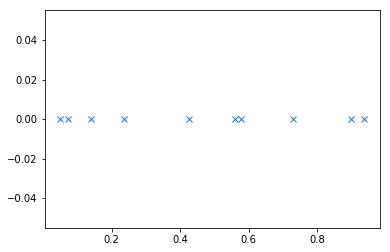

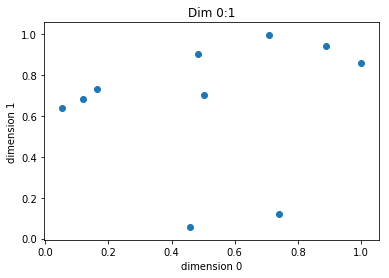

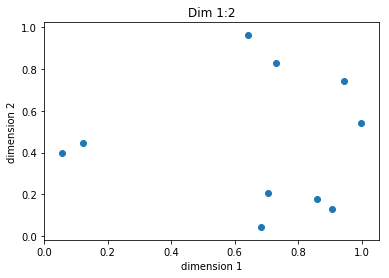

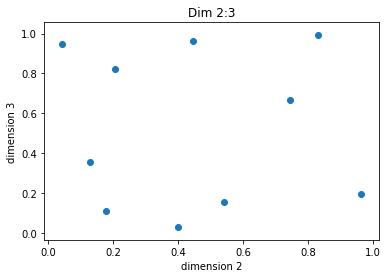

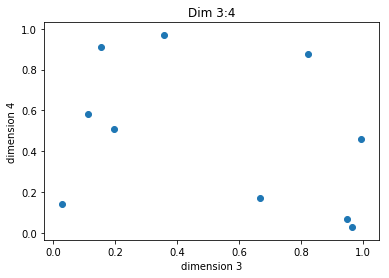

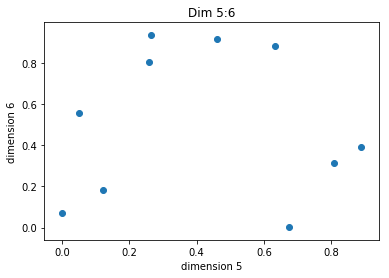

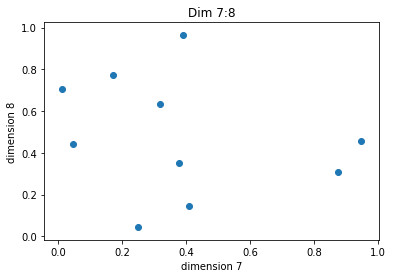

Individual #5


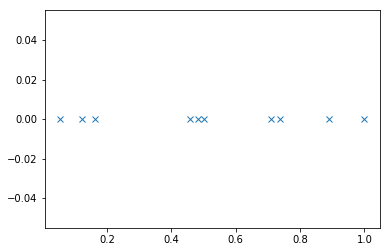

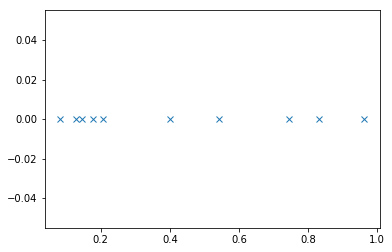

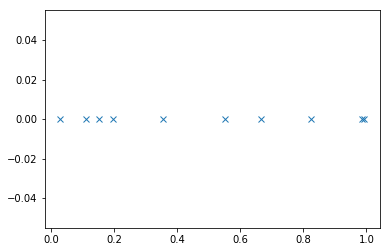

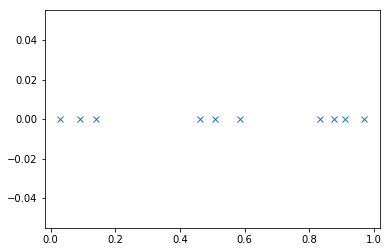

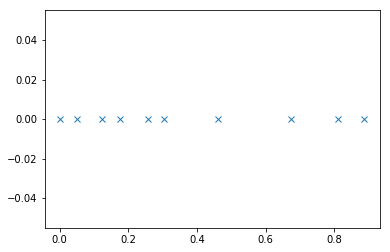

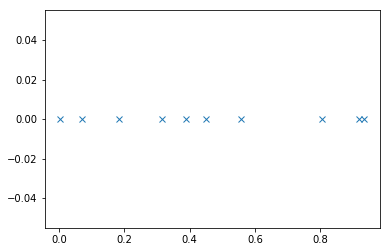

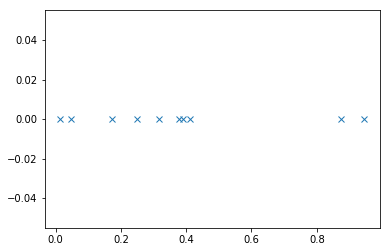

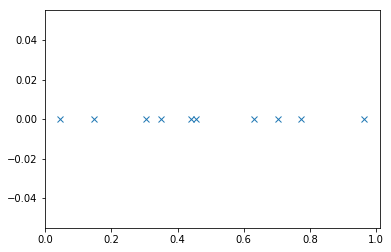

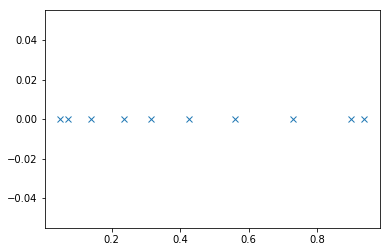

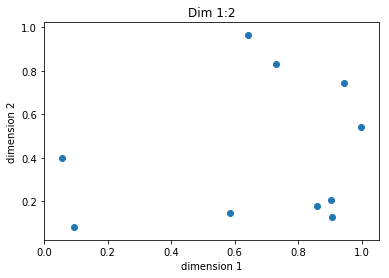

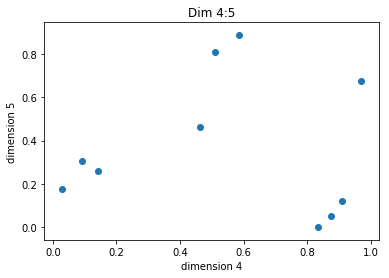

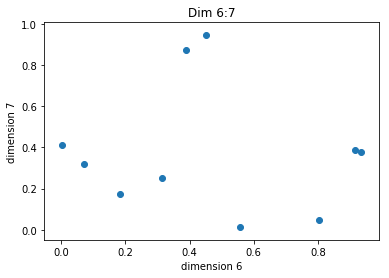

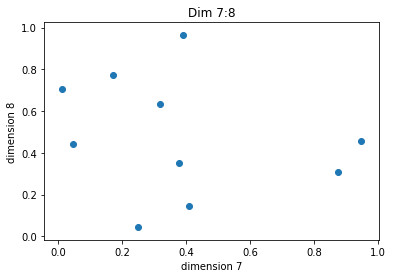

In [0]:
visualize_individuals(hof)
# visualize_pareto(hof)

## Visualisation des critères au cours des générations

In [0]:
max_KL_over_gen = [item["max"][0] for item in stats]
max_KL_projection_over_gen = [item["max"][1] for item in stats]

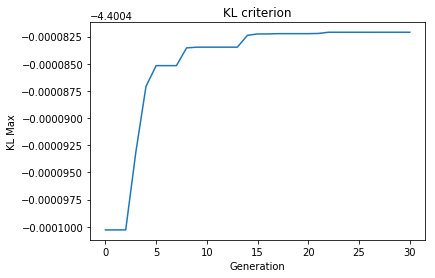

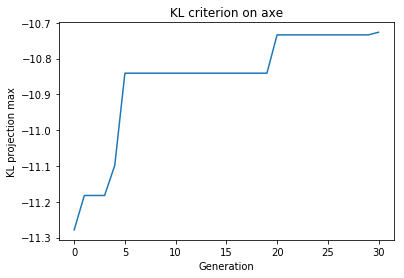

In [0]:
fig = plt.figure()
plt.title('KL criterion')
plt.plot(range(0,NGEN+1), max_KL_over_gen)
plt.xlabel('Generation')
plt.ylabel('KL Max')
plt.show()

fig = plt.figure()
plt.title('KL criterion on axe')
plt.plot(range(0,NGEN+1), max_KL_projection_over_gen)
plt.xlabel('Generation')
plt.ylabel('KL projection max')
plt.show()